In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import numpy as np 
import pandas as pd 

import os

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, log_loss, f1_score, precision_score, recall_score
from sklearn.ensemble import ExtraTreesClassifier

from lightgbm import LGBMClassifier

import random

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

In [ ]:
df = pd.DataFrame()
for i in range(1,10):
  temp = pd.read_csv(f'/content/drive/MyDrive/embeddings/fastText_{i}.vectors.txt', delimiter=' ', skiprows=1, header = None)
  temp['Family'] = i
  df = pd.concat([df, temp],axis=0)

test = pd.read_csv('/content/drive/MyDrive/FYP/OPCODES_Clean/test_set.csv')

In [ ]:
df['Family'] = df['Family'] - 1

In [ ]:
temp_df = pd.read_csv('/content/drive/MyDrive/FYP/OPCODES_Clean/dataset.csv')

In [ ]:
temp_df = pd.DataFrame(df.rename({0:'ID'}, axis=1)['ID']).merge(temp_df, on='ID').reset_index(drop = True)

In [ ]:
temp_df['Opcodes'] = temp_df['Opcodes'].apply(lambda x: str(x).replace(',',' '))

In [ ]:
vectorizer = TfidfVectorizer()
tf_encs = vectorizer.fit_transform(temp_df['Opcodes'])
tf_encs = tf_encs.toarray()

In [ ]:
# tf_encs.shape

In [ ]:
# df.shape

In [ ]:
Xx = pd.DataFrame(tf_encs)

In [ ]:
# Xx = pd.concat([pd.DataFrame(df.drop([0,'Family'],axis=1).values), pd.DataFrame(tf_encs, columns = np.arange(100, 100+99) )] , axis=1)

In [ ]:
# df = df.sample(frac=1).reset_index(drop = True)
df = df.reset_index(drop = True)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,Family
0,01kcPWA9K2BOxQeS5Rju,0.490019,0.246652,-0.074752,0.199995,0.257202,-0.264481,-0.094200,0.300277,-0.100951,-0.068712,-0.101893,-0.081141,-0.237977,-0.213057,-0.214349,-0.151692,-0.463176,-0.375645,0.070504,-0.118931,-0.091333,0.096341,-0.046842,-0.066605,0.313323,-0.342228,0.546364,0.058887,0.461288,0.459364,0.099104,-0.292026,0.185670,-0.048741,-0.395042,0.598792,0.398118,-0.194364,0.408601,...,-0.521503,0.350581,0.125442,-0.123124,0.179164,0.149540,-0.321353,0.204498,0.052053,-0.240429,-0.062793,-0.287057,0.310950,-0.073131,0.395020,0.274725,0.308745,0.320110,-0.789970,-0.086179,-0.249084,-0.118299,0.115802,0.255755,-0.134587,-0.244400,-0.088909,0.116641,-0.472341,0.277205,-0.204946,-0.234757,0.355260,-0.334045,0.304022,-0.548293,0.540579,0.159466,-0.021599,0
1,04EjIdbPV5e1XroFOpiN,0.586597,0.342761,-0.349374,0.650660,0.302345,-0.101330,-0.123291,0.080003,-0.044311,-0.279998,-0.284378,0.103144,-0.108411,-0.331293,-0.356329,-0.266312,-0.416170,-0.514190,0.116165,-0.161516,-0.243866,0.144189,-0.141394,-0.056593,0.200338,-0.291706,0.604840,-0.095667,0.471635,0.421685,0.096001,-0.421567,0.155400,0.029452,-0.581137,0.631508,0.521313,-0.248629,0.440763,...,-0.446663,0.358576,0.073770,0.028866,0.281874,0.226235,-0.485920,0.268613,0.030928,-0.241248,-0.009872,-0.210190,0.440853,0.175935,0.299564,0.327844,0.496241,0.421131,-0.751047,0.058994,-0.153683,-0.052271,0.051105,0.255610,-0.329366,-0.119494,-0.047586,0.197049,-0.785149,0.577412,-0.227859,-0.148124,0.080779,-0.384289,0.289509,-0.443804,0.801727,0.255491,-0.051095,0
2,05EeG39MTRrI6VY21DPd,0.638156,0.360327,-0.485862,0.875609,0.359884,-0.016388,-0.142252,-0.039224,-0.011038,-0.350613,-0.369287,0.182183,-0.015326,-0.372009,-0.421265,-0.315692,-0.336878,-0.508274,0.159346,-0.199092,-0.388960,0.188155,-0.241070,-0.060406,0.116476,-0.289276,0.674889,-0.158050,0.442525,0.400663,0.127171,-0.477220,0.077335,0.193657,-0.774284,0.636418,0.583869,-0.228336,0.409760,...,-0.410641,0.298947,0.019589,0.099624,0.337264,0.153916,-0.406953,0.231565,0.049634,-0.261310,0.082396,-0.110998,0.497566,0.254905,0.223751,0.298713,0.534464,0.432591,-0.709459,0.126500,-0.067534,-0.086347,0.023501,0.210622,-0.458374,-0.004700,-0.069754,0.202053,-0.868032,0.767907,-0.161850,-0.121352,-0.040297,-0.399245,0.278657,-0.353547,0.892944,0.446620,0.085298,0
3,05rJTUWYAKNegBk2wE8X,0.501801,0.331249,-0.220678,0.483981,0.270285,-0.139000,-0.087160,0.180803,-0.082140,-0.190506,-0.275629,0.071135,-0.173846,-0.330906,-0.301508,-0.262865,-0.438026,-0.480108,0.046024,-0.119445,-0.149418,0.112743,-0.034468,-0.091652,0.253392,-0.324379,0.574037,0.021738,0.484119,0.459770,0.096974,-0.423764,0.204578,0.000395,-0.437208,0.643457,0.464318,-0.256347,0.438487,...,-0.463688,0.359682,0.081897,-0.033641,0.254571,0.274445,-0.527214,0.282721,0.014875,-0.227590,-0.106744,-0.221695,0.392925,0.081955,0.338994,0.325235,0.480844,0.441486,-0.773561,0.034521,-0.176829,-0.030755,0.048714,0.302958,-0.256488,-0.154222,-0.060738,0.186817,-0.687391,0.462631,-0.234995,-0.167081,0.155181,-0.385319,0.300084,-0.539238,0.786507,0.151410,-0.157954,0
4,0AnoOZDNbPXIr2MRBSCJ,0.472549,0.223478,-0.309006,0.503769,0.265821,-0.071450,-0.121231,0.032157,-0.039314,-0.315629,-0.234585,0.145729,-0.087294,-0.187213,-0.298732,-0.120153,-0.246560,-0.328123,0.096126,-0.172714,-0.296455,0.159087,-0.183643,-0.031508,0.147012,-0.189497,0.546924,-0.073934,0.298367,0.289246,0.088544,-0.342806,0.073357,0.155546,-0.526899,0.442196,0.541162,-0.149903,0.361654,...,-0.352678,0.213451,-0.020089,0.115730,0.217626,0.087740,-0.306696,0.218360,-0.024652,-0.225284,0.092780,-0.096985,0.414296,0.132857,0.213662,0.268258,0.394024,0.268796,-0.496828,0.127851,-0.078787,-0.071962,0.065248,0.139557,-0.279566,-0.001808,0.025021,0.103069,-0.563332,0.471222

In [ ]:
df['Family'].value_counts()

2    2942
1    2478
0    1541
7    1228
8    1013
5     751
3     475
6     398
4      42
Name: Family, dtype: int64

# Neural Network

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
import tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F

In [ ]:
def train_model(data_loader, model, optimizer, device):
  """
  This function does training for one epoch
  :param data_loader: this is the pytorch dataloader
  :param model: pytorch model
  :param optimizer: optimizer, for e.g. adam, sgd, etc
  :param device: cuda/cpu
  """
  # put the model in train mode
  model.train()
  # scheduler = get_scheduler(optimizer, 'CosineAnnealingWarmRestarts')
  # go over every batch of data in data loader
  for data in tqdm.tqdm(data_loader):
    # remember, we have image and targets
    # in our dataset class
    inputs = data["X"]
    targets = data["targets"]
    
    # move inputs/targets to cuda/cpu device
    inputs = inputs.to(device, dtype=torch.float)
    targets = targets.to(device, dtype=torch.float)
    
    # zero grad the optimizer
    optimizer.zero_grad()
    #do the forward step of model
    outputs = model(inputs)
    # calculate loss
    
    loss = nn.CrossEntropyLoss()(outputs,targets.long())
    # backward step the loss
    loss.backward()
    # step optimizer
    optimizer.step()
    # if you have a scheduler, you either need to
    # step it here or you have to step it after
    # the epoch. here, we are not using any learning
    # rate scheduler
  # scheduler.step()
    
def evaluate_model(data_loader, model, device):
  """
  This function does evaluation for one epoch
  :param data_loader: this is the pytorch dataloader
  :param model: pytorch model
  :param device: cuda/cpu
  """
  # put model in evaluation mode
  model.eval()
  
  # init lists to store targets and outputs
  final_targets = []
  final_outputs = []
  
  # we use no_grad context
  with torch.no_grad():
    for data in tqdm.tqdm(data_loader):
      inputs = data["X"]
      targets = data["targets"]
      inputs = inputs.to(device, dtype=torch.float)
      targets = targets.to(device, dtype=torch.float)
      
      # do the forward step to generate prediction
      output = model(inputs)
      
      # convert targets and outputs to lists
      targets = targets.detach().cpu().numpy().tolist()
      output = output.detach().cpu().numpy().tolist()
      
      # extend the original list
      final_targets.extend(targets)
      final_outputs.extend(output)
      
  # return final output and final targets
  return final_outputs, final_targets

import os
def save_checkpoint(model, optimizer, path):
    if not os.path.exists(os.path.dirname(path)):
        print("Creating directories on path: `{}`".format(path))
        os.makedirs(os.path.dirname(path))

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, path)


def load_checkpoint(model, path):
    checkpoint = torch.load(path)

    model.load_state_dict(checkpoint["model_state_dict"])

    optimizer = torch.optim.Adam(model.parameters())
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    return model, optimizer


def save_model(model, path):
  if not os.path.exists(os.path.dirname(path)):
      print("Creating directories on path: `{}`".format(path))
      os.makedirs(os.path.dirname(path))

  torch.save({
      "model_state_dict": model.state_dict(),
  }, path)


def load_model(model, path):
  restore_dict = torch.load(path)

  model.load_state_dict(restore_dict["model_state_dict"])
  model.eval()

  return model

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

def get_scheduler(optimizer, scheduler):
    if scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, verbose=True, eps=1e-6)
    elif scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1)
    elif scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
    return scheduler

In [ ]:
LSTM_UNITS = 128
GRU_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 100

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_shape, num_aux_targets):
        super(NeuralNet, self).__init__()
        self.lstm = nn.LSTM(input_shape, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(input_shape, GRU_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(GRU_UNITS*2, DENSE_HIDDEN_UNITS)

        self.attention = nn.Sequential(            
            nn.Linear(DENSE_HIDDEN_UNITS, 256),            
            nn.Tanh(),                       
            nn.Linear(256, 1),
            nn.Softmax(dim=1)
        )  
        
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        # self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x):
        x = x.view((-1,1,100))
        h_lstm, _ = self.lstm(x)
        h_gru, _ = self.gru(x)
        
        h_lstm = h_lstm.squeeze()
        h_gru = h_gru.squeeze()

        # global average pooling
        # avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        # max_pool, _ = torch.max(h_lstm2, 1)
        
        # h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_lstm))
        h_conc_linear2  = F.relu(self.linear2(h_gru))
        
        hidden = (h_conc_linear1 + h_conc_linear2)/2
      
        weights = self.attention(hidden)

        context_vector = weights * hidden      
        
        # print(context_vector.shape)
        # print(weights.shape)
        # print(hidden.shape)

        results = self.linear_out(context_vector)

        return nn.Softmax(dim=1)(results)

In [ ]:
import pickle
from sklearn.model_selection import StratifiedKFold

In [ ]:
class Dataset:
  def __init__(self, X, targets):
    self.X = X
    self.target = targets
    
  def __len__(self):
    return len(self.X)
    
  def __getitem__(self, item):
    X = self.X[item, :]
    target = self.target[item]
    return {
      "X": torch.tensor(X, dtype=torch.float),
      "targets": torch.tensor(target, dtype=torch.float)
    }

In [ ]:
epochs = 50
device = 'cuda'

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn import metrics

In [ ]:
i = 0
fold = 4
logloss_list, f1_list, recall_list, precision_list, accuracy_list = [], [], [], [], [] 
for tr_in, val_in in StratifiedKFold(n_splits=5, shuffle=True).split(df, df['Family']):
  x_train = df.drop([0, 'Family'],axis=1).loc[tr_in, :]
  x_test = df.drop([0, 'Family'],axis=1).loc[val_in, :]
  y_train = df.loc[tr_in, 'Family']
  y_test = df.loc[val_in, 'Family']

  xx_train = Xx.loc[tr_in, :]
  xx_test = Xx.loc[val_in, :]

  model = NeuralNet(100, 9).to(device)

  train_dataset = Dataset(
    x_train.values,
    y_train.values
  )
  train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=4
  )

  valid_dataset = Dataset(
    x_test.values,
    y_test.values
  )

  valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=4
  )
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

  lgbm = LGBMClassifier(n_jobs=-1)
  xgb = XGBClassifier(n_jobs=-1)

  lgbm.fit(xx_train.values, y_train.values)
  xgb.fit(xx_train.values, y_train.values)

  pickle.dump(lgbm, open(f'./lgbm_fold{i}.b5', 'wb'))
  pickle.dump(xgb, open(f'./xgb_fold{i}.b5', 'wb'))

  best_logloss = 10
  for epoch in range(epochs):
      train_model(train_loader, model, optimizer, device=device)

      predictions, valid_targets = evaluate_model(
        valid_loader, model, device=device
      )
      
      lgbm_preds = lgbm.predict_proba(xx_test.values)
      xgb_preds = xgb.predict_proba(xx_test.values)

      predictions = (np.array(predictions) * 0.05 + lgbm_preds * 0.45 + xgb_preds * 0.4)

      logloss = metrics.log_loss(valid_targets, predictions)
      f1 = metrics.f1_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      recall = metrics.recall_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      precision = metrics.precision_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      accuracy = metrics.accuracy_score(valid_targets, np.array(predictions).argmax(axis=1))

      logloss_list.append(logloss)
      f1_list.append(f1)
      recall_list.append(recall)
      precision_list.append(precision)
      accuracy_list.append(accuracy)

      print(
        f"Epoch={epoch} \nValidation: = Logloss: {logloss} F1: {f1} Recall: {recall} Precision: {precision} Accuracy: {accuracy}"
      )
      if logloss < best_logloss:
        save_checkpoint(model, optimizer, f'./model_fold{i}_{epoch}.pth')
        best_logloss = logloss
  i += 1

100%|██████████| 34/34 [00:00<00:00, 68.56it/s]


Epoch=0 
Validation: = Logloss: 0.06343739350980468 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.11it/s]


Epoch=1 
Validation: = Logloss: 0.06130940825655613 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 74.76it/s] 


Epoch=2 
Validation: = Logloss: 0.06080868447424478 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 74.30it/s]


Epoch=3 
Validation: = Logloss: 0.058039584485365114 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 75.98it/s]


Epoch=4 
Validation: = Logloss: 0.0576685058272393 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 71.17it/s]


Epoch=5 
Validation: = Logloss: 0.057209968080577565 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 74.22it/s]


Epoch=6 
Validation: = Logloss: 0.05727039815839721 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 72.28it/s]


Epoch=7 
Validation: = Logloss: 0.05704496848295257 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.87it/s]


Epoch=8 
Validation: = Logloss: 0.05692590491061167 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 71.80it/s]


Epoch=9 
Validation: = Logloss: 0.0569034824177584 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 74.89it/s] 


Epoch=10 
Validation: = Logloss: 0.05666524812028956 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.34it/s]


Epoch=11 
Validation: = Logloss: 0.0563947868529875 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.02it/s]


Epoch=12 
Validation: = Logloss: 0.056657852681411956 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.56it/s]


Epoch=13 
Validation: = Logloss: 0.056752062915389374 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.60it/s]


Epoch=14 
Validation: = Logloss: 0.05617456538426548 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.37it/s]


Epoch=15 
Validation: = Logloss: 0.055828185373821636 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 48.75it/s]


Epoch=16 
Validation: = Logloss: 0.05587201353731606 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 71.65it/s]


Epoch=17 
Validation: = Logloss: 0.056023323237911066 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.44it/s]


Epoch=18 
Validation: = Logloss: 0.05594086183882249 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 74.03it/s]


Epoch=19 
Validation: = Logloss: 0.05584577575231085 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 71.31it/s]


Epoch=20 
Validation: = Logloss: 0.05597294280848651 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 72.06it/s]


Epoch=21 
Validation: = Logloss: 0.05643730005929884 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.58it/s]


Epoch=22 
Validation: = Logloss: 0.05628999475190963 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 70.84it/s]


Epoch=23 
Validation: = Logloss: 0.056403561206814855 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 75.11it/s] 


Epoch=24 
Validation: = Logloss: 0.056336164911810226 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 69.49it/s]


Epoch=25 
Validation: = Logloss: 0.05609157745978098 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.69it/s]


Epoch=26 
Validation: = Logloss: 0.0565396792451591 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.50it/s]


Epoch=27 
Validation: = Logloss: 0.05613028171507019 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 74.25it/s]


Epoch=28 
Validation: = Logloss: 0.05612702635816886 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.91it/s]


Epoch=29 
Validation: = Logloss: 0.05609241034948185 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.33it/s]


Epoch=30 
Validation: = Logloss: 0.05626405630498759 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 71.38it/s]


Epoch=31 
Validation: = Logloss: 0.05597252416531836 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 71.27it/s]


Epoch=32 
Validation: = Logloss: 0.056029300547024395 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 74.96it/s]


Epoch=33 
Validation: = Logloss: 0.056170968053183334 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.01it/s]


Epoch=34 
Validation: = Logloss: 0.056119050326421345 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.59it/s]


Epoch=35 
Validation: = Logloss: 0.0561209960417996 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.68it/s]


Epoch=36 
Validation: = Logloss: 0.0561927182181566 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 71.46it/s]


Epoch=37 
Validation: = Logloss: 0.056134387231168856 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.99it/s]


Epoch=38 
Validation: = Logloss: 0.05604815386932557 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.08it/s]


Epoch=39 
Validation: = Logloss: 0.05654790458792081 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 62.62it/s]


Epoch=40 
Validation: = Logloss: 0.055943323323629876 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 71.17it/s]


Epoch=41 
Validation: = Logloss: 0.0559808419918223 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 72.25it/s]


Epoch=42 
Validation: = Logloss: 0.05597347157963038 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 65.50it/s]


Epoch=43 
Validation: = Logloss: 0.056277376605715135 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 71.00it/s]


Epoch=44 
Validation: = Logloss: 0.05598954113740929 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 69.79it/s]


Epoch=45 
Validation: = Logloss: 0.055900799565728146 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 71.89it/s]


Epoch=46 
Validation: = Logloss: 0.05591361110002767 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 70.07it/s]


Epoch=47 
Validation: = Logloss: 0.05607335997869936 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 73.79it/s]


Epoch=48 
Validation: = Logloss: 0.05614000976065316 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 66.46it/s]


Epoch=49 
Validation: = Logloss: 0.0559394521564516 F1: 0.9885004599816007 Recall: 0.9885004599816007 Precision: 0.9885004599816007 Accuracy: 0.9885004599816007


100%|██████████| 34/34 [00:00<00:00, 68.21it/s]


Epoch=0 
Validation: = Logloss: 0.05264517967987616 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 70.22it/s]


Epoch=1 
Validation: = Logloss: 0.05093815472787396 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 68.47it/s]


Epoch=2 
Validation: = Logloss: 0.050497894438516884 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 68.64it/s]


Epoch=3 
Validation: = Logloss: 0.046837752728743305 F1: 0.9912603495860166 Recall: 0.9912603495860166 Precision: 0.9912603495860166 Accuracy: 0.9912603495860166


100%|██████████| 34/34 [00:00<00:00, 70.46it/s]


Epoch=4 
Validation: = Logloss: 0.04627902556898815 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 73.07it/s]


Epoch=5 
Validation: = Logloss: 0.04613505438992358 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 72.18it/s]


Epoch=6 
Validation: = Logloss: 0.04628611879089273 F1: 0.9912603495860166 Recall: 0.9912603495860166 Precision: 0.9912603495860166 Accuracy: 0.9912603495860166


100%|██████████| 34/34 [00:00<00:00, 71.78it/s]


Epoch=7 
Validation: = Logloss: 0.04586621954901265 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 67.07it/s]


Epoch=8 
Validation: = Logloss: 0.045312530746375076 F1: 0.9912603495860166 Recall: 0.9912603495860166 Precision: 0.9912603495860166 Accuracy: 0.9912603495860166


100%|██████████| 34/34 [00:00<00:00, 70.37it/s]


Epoch=9 
Validation: = Logloss: 0.045242648022758875 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 69.53it/s]


Epoch=10 
Validation: = Logloss: 0.04528475726355893 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 72.77it/s]


Epoch=11 
Validation: = Logloss: 0.0447542375931383 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 72.70it/s]


Epoch=12 
Validation: = Logloss: 0.04448462166217358 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 66.12it/s]


Epoch=13 
Validation: = Logloss: 0.04461734814688199 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 70.27it/s]


Epoch=14 
Validation: = Logloss: 0.04415766090582387 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 71.42it/s]


Epoch=15 
Validation: = Logloss: 0.04389705299915364 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 71.02it/s]


Epoch=16 
Validation: = Logloss: 0.04380421872455105 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 72.36it/s]


Epoch=17 
Validation: = Logloss: 0.04390283283321359 F1: 0.9912603495860166 Recall: 0.9912603495860166 Precision: 0.9912603495860166 Accuracy: 0.9912603495860166


100%|██████████| 34/34 [00:00<00:00, 70.56it/s]


Epoch=18 
Validation: = Logloss: 0.04397948408520765 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 72.57it/s]


Epoch=19 
Validation: = Logloss: 0.04363602622719087 F1: 0.9912603495860166 Recall: 0.9912603495860166 Precision: 0.9912603495860166 Accuracy: 0.9912603495860166


100%|██████████| 34/34 [00:00<00:00, 71.45it/s]


Epoch=20 
Validation: = Logloss: 0.04403978973569218 F1: 0.9912603495860166 Recall: 0.9912603495860166 Precision: 0.9912603495860166 Accuracy: 0.9912603495860166


100%|██████████| 34/34 [00:00<00:00, 69.24it/s]


Epoch=21 
Validation: = Logloss: 0.044531713956991924 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 73.09it/s]


Epoch=22 
Validation: = Logloss: 0.043341192301259136 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 59.61it/s]


Epoch=23 
Validation: = Logloss: 0.04338825801958903 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 70.21it/s]


Epoch=24 
Validation: = Logloss: 0.04341842323059933 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 72.66it/s]


Epoch=25 
Validation: = Logloss: 0.04344968596232469 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 63.40it/s]


Epoch=26 
Validation: = Logloss: 0.04364901564415505 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 70.61it/s]


Epoch=27 
Validation: = Logloss: 0.04348189963228929 F1: 0.9912603495860166 Recall: 0.9912603495860166 Precision: 0.9912603495860166 Accuracy: 0.9912603495860166


100%|██████████| 34/34 [00:00<00:00, 65.10it/s]


Epoch=28 
Validation: = Logloss: 0.04333201250966468 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 69.12it/s]


Epoch=29 
Validation: = Logloss: 0.043245981246485106 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 71.99it/s]


Epoch=30 
Validation: = Logloss: 0.04363397056304371 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 69.44it/s]


Epoch=31 
Validation: = Logloss: 0.04300835711305488 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 65.17it/s]


Epoch=32 
Validation: = Logloss: 0.043157066695191225 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 66.50it/s]


Epoch=33 
Validation: = Logloss: 0.0432688081452634 F1: 0.9912603495860166 Recall: 0.9912603495860166 Precision: 0.9912603495860166 Accuracy: 0.9912603495860166


100%|██████████| 34/34 [00:00<00:00, 68.74it/s]


Epoch=34 
Validation: = Logloss: 0.043212075504573524 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 70.50it/s]


Epoch=35 
Validation: = Logloss: 0.0430994979608209 F1: 0.9912603495860166 Recall: 0.9912603495860166 Precision: 0.9912603495860166 Accuracy: 0.9912603495860166


100%|██████████| 34/34 [00:00<00:00, 72.26it/s]


Epoch=36 
Validation: = Logloss: 0.04312369102625597 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 72.34it/s]


Epoch=37 
Validation: = Logloss: 0.04323249328984122 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 71.20it/s]


Epoch=38 
Validation: = Logloss: 0.042895916668717025 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 72.05it/s]


Epoch=39 
Validation: = Logloss: 0.043103587393719896 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 68.64it/s]


Epoch=40 
Validation: = Logloss: 0.04321330125646371 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 73.21it/s]


Epoch=41 
Validation: = Logloss: 0.04298401593908998 F1: 0.9912603495860166 Recall: 0.9912603495860166 Precision: 0.9912603495860166 Accuracy: 0.9912603495860166


100%|██████████| 34/34 [00:00<00:00, 72.33it/s]


Epoch=42 
Validation: = Logloss: 0.04305330304082659 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 70.33it/s]


Epoch=43 
Validation: = Logloss: 0.043098449794826944 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 70.90it/s]


Epoch=44 
Validation: = Logloss: 0.04301946608682894 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 69.66it/s]


Epoch=45 
Validation: = Logloss: 0.043108737387424254 F1: 0.9912603495860166 Recall: 0.9912603495860166 Precision: 0.9912603495860166 Accuracy: 0.9912603495860166


100%|██████████| 34/34 [00:00<00:00, 68.15it/s]


Epoch=46 
Validation: = Logloss: 0.04291743552287715 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 66.11it/s]


Epoch=47 
Validation: = Logloss: 0.042925700059196055 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 70.44it/s]


Epoch=48 
Validation: = Logloss: 0.043270279245926115 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 68.73it/s]


Epoch=49 
Validation: = Logloss: 0.04302239208348049 F1: 0.9908003679852806 Recall: 0.9908003679852806 Precision: 0.9908003679852806 Accuracy: 0.9908003679852806


100%|██████████| 34/34 [00:00<00:00, 69.81it/s]


Epoch=0 
Validation: = Logloss: 0.06384741145954138 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 71.51it/s]


Epoch=1 
Validation: = Logloss: 0.06285233645918957 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 67.98it/s]


Epoch=2 
Validation: = Logloss: 0.05938365779894338 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 71.58it/s]


Epoch=3 
Validation: = Logloss: 0.05871437802938012 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.88it/s]


Epoch=4 
Validation: = Logloss: 0.058662179153537754 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 71.22it/s]


Epoch=5 
Validation: = Logloss: 0.058410480121361644 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 66.98it/s]


Epoch=6 
Validation: = Logloss: 0.05827772031447215 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.45it/s]


Epoch=7 
Validation: = Logloss: 0.05833815772563247 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 72.52it/s]


Epoch=8 
Validation: = Logloss: 0.05733952176774137 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 70.33it/s]


Epoch=9 
Validation: = Logloss: 0.057137890878019605 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 71.35it/s]


Epoch=10 
Validation: = Logloss: 0.05710678951705009 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 70.89it/s]


Epoch=11 
Validation: = Logloss: 0.05658538867333265 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 71.74it/s]


Epoch=12 
Validation: = Logloss: 0.056611333411849714 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 67.09it/s]


Epoch=13 
Validation: = Logloss: 0.05622644202297714 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 63.76it/s]


Epoch=14 
Validation: = Logloss: 0.056212784405917954 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.01it/s]


Epoch=15 
Validation: = Logloss: 0.05603339018786297 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.22it/s]


Epoch=16 
Validation: = Logloss: 0.05626472213060529 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 68.63it/s]


Epoch=17 
Validation: = Logloss: 0.05539134476140236 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 72.89it/s]


Epoch=18 
Validation: = Logloss: 0.055482048487371635 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 70.76it/s]


Epoch=19 
Validation: = Logloss: 0.05546369593512833 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 71.22it/s]


Epoch=20 
Validation: = Logloss: 0.055577226673887065 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.06it/s]


Epoch=21 
Validation: = Logloss: 0.055362259176656964 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.49it/s]


Epoch=22 
Validation: = Logloss: 0.055475745235067576 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 68.65it/s]


Epoch=23 
Validation: = Logloss: 0.055260214484272846 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 73.72it/s]


Epoch=24 
Validation: = Logloss: 0.05520299807869117 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 70.14it/s]


Epoch=25 
Validation: = Logloss: 0.055299280456164196 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.83it/s]


Epoch=26 
Validation: = Logloss: 0.05512696557094622 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 71.45it/s]


Epoch=27 
Validation: = Logloss: 0.05509714903475209 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 71.50it/s]


Epoch=28 
Validation: = Logloss: 0.05511445697645976 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 65.31it/s]


Epoch=29 
Validation: = Logloss: 0.05545787512572719 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.84it/s]


Epoch=30 
Validation: = Logloss: 0.055104376802805326 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 67.82it/s]


Epoch=31 
Validation: = Logloss: 0.05510301594050085 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 63.83it/s]


Epoch=32 
Validation: = Logloss: 0.0550743818701424 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 68.16it/s]


Epoch=33 
Validation: = Logloss: 0.05514597277182503 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 66.37it/s]


Epoch=34 
Validation: = Logloss: 0.05501271830130455 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 68.92it/s]


Epoch=35 
Validation: = Logloss: 0.055023849664872344 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 67.61it/s]


Epoch=36 
Validation: = Logloss: 0.05527343811559384 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.18it/s]


Epoch=37 
Validation: = Logloss: 0.054959395567989726 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 65.27it/s]


Epoch=38 
Validation: = Logloss: 0.05537696795771784 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.28it/s]


Epoch=39 
Validation: = Logloss: 0.05482568855058245 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 68.09it/s]


Epoch=40 
Validation: = Logloss: 0.05481495271304826 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.18it/s]


Epoch=41 
Validation: = Logloss: 0.05490469783207638 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 65.43it/s]


Epoch=42 
Validation: = Logloss: 0.05512493140662825 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 67.16it/s]


Epoch=43 
Validation: = Logloss: 0.0550444296002804 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 69.38it/s]


Epoch=44 
Validation: = Logloss: 0.054869294189148356 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 48.27it/s]


Epoch=45 
Validation: = Logloss: 0.054848606733408 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 71.07it/s]


Epoch=46 
Validation: = Logloss: 0.05477653593551138 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 67.72it/s]


Epoch=47 
Validation: = Logloss: 0.054960523404003675 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 71.86it/s]


Epoch=48 
Validation: = Logloss: 0.05495089007167393 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 68.34it/s]


Epoch=49 
Validation: = Logloss: 0.05499771742503661 F1: 0.9871205151793928 Recall: 0.9871205151793928 Precision: 0.9871205151793928 Accuracy: 0.9871205151793928


100%|██████████| 34/34 [00:00<00:00, 68.55it/s]


Epoch=0 
Validation: = Logloss: 0.0621107590817279 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 68.56it/s]


Epoch=1 
Validation: = Logloss: 0.058587473056386556 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 70.18it/s]


Epoch=2 
Validation: = Logloss: 0.05526072282964464 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 64.88it/s]


Epoch=3 
Validation: = Logloss: 0.05524172235777056 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 69.42it/s]


Epoch=4 
Validation: = Logloss: 0.05497466693884352 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 67.05it/s]


Epoch=5 
Validation: = Logloss: 0.05497935008217109 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 69.72it/s]


Epoch=6 
Validation: = Logloss: 0.0548765001765712 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 68.41it/s]


Epoch=7 
Validation: = Logloss: 0.05520913893413821 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 69.09it/s]


Epoch=8 
Validation: = Logloss: 0.05522371354654199 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 68.52it/s]


Epoch=9 
Validation: = Logloss: 0.05551432399621013 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 47.12it/s]


Epoch=10 
Validation: = Logloss: 0.05511988234366969 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 71.38it/s]


Epoch=11 
Validation: = Logloss: 0.055336564741140806 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 66.53it/s]


Epoch=12 
Validation: = Logloss: 0.05527900137686225 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 65.80it/s]


Epoch=13 
Validation: = Logloss: 0.05524404122949259 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 66.09it/s]


Epoch=14 
Validation: = Logloss: 0.05519139336477239 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 67.12it/s]


Epoch=15 
Validation: = Logloss: 0.054929483008324745 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 67.43it/s]


Epoch=16 
Validation: = Logloss: 0.05475992638831012 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 70.49it/s]


Epoch=17 
Validation: = Logloss: 0.05486019017561974 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 66.31it/s]


Epoch=18 
Validation: = Logloss: 0.05493509204904781 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 67.97it/s]


Epoch=19 
Validation: = Logloss: 0.05455795858611323 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 69.78it/s]


Epoch=20 
Validation: = Logloss: 0.05491943352725658 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 68.36it/s]


Epoch=21 
Validation: = Logloss: 0.0547484841652707 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 68.21it/s]


Epoch=22 
Validation: = Logloss: 0.05465301100092962 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 68.56it/s]


Epoch=23 
Validation: = Logloss: 0.05457373432053776 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 69.86it/s]


Epoch=24 
Validation: = Logloss: 0.05476302956103258 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 67.37it/s]


Epoch=25 
Validation: = Logloss: 0.05465223853983363 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 59.28it/s]


Epoch=26 
Validation: = Logloss: 0.054497740827727355 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 68.57it/s]


Epoch=27 
Validation: = Logloss: 0.05423735620518771 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 66.52it/s]


Epoch=28 
Validation: = Logloss: 0.05426038642567172 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 69.64it/s]


Epoch=29 
Validation: = Logloss: 0.05415766539601145 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 66.51it/s]


Epoch=30 
Validation: = Logloss: 0.05416205637094349 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 70.52it/s]


Epoch=31 
Validation: = Logloss: 0.05429440944173717 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 66.24it/s]


Epoch=32 
Validation: = Logloss: 0.05424910928624548 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 67.36it/s]


Epoch=33 
Validation: = Logloss: 0.054017696382262496 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 69.75it/s]


Epoch=34 
Validation: = Logloss: 0.05420082068551243 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 66.45it/s]


Epoch=35 
Validation: = Logloss: 0.0541614261520397 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 67.42it/s]


Epoch=36 
Validation: = Logloss: 0.054289190188677575 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 67.23it/s]


Epoch=37 
Validation: = Logloss: 0.054482774778733103 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 66.96it/s]


Epoch=38 
Validation: = Logloss: 0.0544293523275518 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 61.55it/s]


Epoch=39 
Validation: = Logloss: 0.05446918694053919 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 65.97it/s]


Epoch=40 
Validation: = Logloss: 0.054658297203296936 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 64.44it/s]


Epoch=41 
Validation: = Logloss: 0.054275582174741294 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 67.23it/s]


Epoch=42 
Validation: = Logloss: 0.05411707460614956 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 69.52it/s]


Epoch=43 
Validation: = Logloss: 0.05460145944599184 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 66.40it/s]


Epoch=44 
Validation: = Logloss: 0.05458542816518606 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 62.75it/s]


Epoch=45 
Validation: = Logloss: 0.05380199649837122 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 65.38it/s]


Epoch=46 
Validation: = Logloss: 0.05386687942889644 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 67.01it/s]


Epoch=47 
Validation: = Logloss: 0.05420863737466939 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 66.00it/s]


Epoch=48 
Validation: = Logloss: 0.05398730105622226 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 67.32it/s]


Epoch=49 
Validation: = Logloss: 0.05401963634991942 F1: 0.9880349746893695 Recall: 0.9880349746893695 Precision: 0.9880349746893695 Accuracy: 0.9880349746893695


100%|██████████| 34/34 [00:00<00:00, 62.87it/s]


Epoch=0 
Validation: = Logloss: 0.06340093392030988 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 70.38it/s]


Epoch=1 
Validation: = Logloss: 0.06265379359046339 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 67.30it/s]


Epoch=2 
Validation: = Logloss: 0.05978602129579339 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 68.98it/s]


Epoch=3 
Validation: = Logloss: 0.057959159756171656 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 63.40it/s]


Epoch=4 
Validation: = Logloss: 0.05457717572323046 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.54it/s]


Epoch=5 
Validation: = Logloss: 0.05343512538850254 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.76it/s]


Epoch=6 
Validation: = Logloss: 0.053340522386434115 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.06it/s]


Epoch=7 
Validation: = Logloss: 0.05276204247732516 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 70.16it/s]


Epoch=8 
Validation: = Logloss: 0.05185917262214507 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 65.48it/s]


Epoch=9 
Validation: = Logloss: 0.05192496826927759 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 67.07it/s]


Epoch=10 
Validation: = Logloss: 0.051633566159481475 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 68.32it/s]


Epoch=11 
Validation: = Logloss: 0.050755127651907414 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 65.72it/s]


Epoch=12 
Validation: = Logloss: 0.051206462459894665 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.95it/s]


Epoch=13 
Validation: = Logloss: 0.05127304263423975 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 64.27it/s]


Epoch=14 
Validation: = Logloss: 0.05103603398043559 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.52it/s]


Epoch=15 
Validation: = Logloss: 0.05175928770605254 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 67.55it/s]


Epoch=16 
Validation: = Logloss: 0.05127628115278223 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.13it/s]


Epoch=17 
Validation: = Logloss: 0.0512266820575905 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.91it/s]


Epoch=18 
Validation: = Logloss: 0.05095418040512415 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 65.20it/s]


Epoch=19 
Validation: = Logloss: 0.05096741476343178 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 67.94it/s]


Epoch=20 
Validation: = Logloss: 0.05090614486743966 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 59.95it/s]


Epoch=21 
Validation: = Logloss: 0.05092519925853246 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.37it/s]


Epoch=22 
Validation: = Logloss: 0.05103832437408825 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 65.15it/s]


Epoch=23 
Validation: = Logloss: 0.05095253503051231 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 63.21it/s]


Epoch=24 
Validation: = Logloss: 0.05115054429096294 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 67.78it/s]


Epoch=25 
Validation: = Logloss: 0.05085962141940449 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 65.71it/s]


Epoch=26 
Validation: = Logloss: 0.05067735108844086 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 64.15it/s]


Epoch=27 
Validation: = Logloss: 0.05097755362381568 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.30it/s]


Epoch=28 
Validation: = Logloss: 0.05095385885388249 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 65.01it/s]


Epoch=29 
Validation: = Logloss: 0.050844376101928414 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.30it/s]


Epoch=30 
Validation: = Logloss: 0.05088704297537787 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 64.83it/s]


Epoch=31 
Validation: = Logloss: 0.05085119051913534 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 69.31it/s]


Epoch=32 
Validation: = Logloss: 0.05083749239030177 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 64.39it/s]


Epoch=33 
Validation: = Logloss: 0.050941996022198795 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.93it/s]


Epoch=34 
Validation: = Logloss: 0.05092341428955519 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 67.11it/s]


Epoch=35 
Validation: = Logloss: 0.050961344629835655 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.04it/s]


Epoch=36 
Validation: = Logloss: 0.05087987882941558 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 65.68it/s]


Epoch=37 
Validation: = Logloss: 0.05075942228893371 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 67.52it/s]


Epoch=38 
Validation: = Logloss: 0.050779406838783944 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.32it/s]


Epoch=39 
Validation: = Logloss: 0.05076073490115673 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.30it/s]


Epoch=40 
Validation: = Logloss: 0.050889066730192334 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.96it/s]


Epoch=41 
Validation: = Logloss: 0.050737482995336675 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 63.83it/s]


Epoch=42 
Validation: = Logloss: 0.05094969319073567 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 63.62it/s]


Epoch=43 
Validation: = Logloss: 0.05110739654256472 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 67.49it/s]


Epoch=44 
Validation: = Logloss: 0.05066392065082059 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.03it/s]


Epoch=45 
Validation: = Logloss: 0.05079391713293711 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 63.68it/s]


Epoch=46 
Validation: = Logloss: 0.05062481885723777 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 66.60it/s]


Epoch=47 
Validation: = Logloss: 0.0508457200687166 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 65.41it/s]


Epoch=48 
Validation: = Logloss: 0.05077916412273559 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


100%|██████████| 34/34 [00:00<00:00, 64.52it/s]


Epoch=49 
Validation: = Logloss: 0.05093674119577534 F1: 0.9884951679705476 Recall: 0.9884951679705476 Precision: 0.9884951679705476 Accuracy: 0.9884951679705476


In [ ]:
# 1:08 - 1:25
class TestDataset:
  def __init__(self, X):
    self.X = X
    
  def __len__(self):
    return len(self.X)
    
  def __getitem__(self, item):
    X = self.X[item, :]
    return {
      "X": torch.tensor(X, dtype=torch.float),
    }

In [ ]:
# class EmbeddingExtractorNeuralNet(nn.Module):
#     def __init__(self, input_shape, num_aux_targets):
#         super(EmbeddingExtractorNeuralNet, self).__init__()
#         self.lstm = nn.LSTM(input_shape, LSTM_UNITS, bidirectional=True, batch_first=True)
#         self.gru = nn.GRU(input_shape, GRU_UNITS, bidirectional=True, batch_first=True)

#         self.linear1 = nn.Linear(LSTM_UNITS*2, DENSE_HIDDEN_UNITS)
#         self.linear2 = nn.Linear(GRU_UNITS*2, DENSE_HIDDEN_UNITS)

#         self.attention = nn.Sequential(            
#             nn.Linear(DENSE_HIDDEN_UNITS, 256),            
#             nn.Tanh(),                       
#             nn.Linear(256, 1),
#             nn.Softmax(dim=1)
#         )  
        
        
#         self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
#         # self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
#     def forward(self, x):
#         x = x.view((-1,1,100))
#         h_lstm, _ = self.lstm(x)
#         h_gru, _ = self.gru(x)
        
#         h_lstm = h_lstm.squeeze()
#         h_gru = h_gru.squeeze()

#         # global average pooling
#         # avg_pool = torch.mean(h_lstm2, 1)
#         # global max pooling
#         # max_pool, _ = torch.max(h_lstm2, 1)
        
#         # h_conc = torch.cat((max_pool, avg_pool), 1)
#         h_conc_linear1  = F.relu(self.linear1(h_lstm))
#         h_conc_linear2  = F.relu(self.linear2(h_gru))
        
#         hidden = (h_conc_linear1 + h_conc_linear2)/2
      
#         weights = self.attention(hidden)

#         context_vector = weights * hidden      
        
#         # print(context_vector.shape)
#         # print(weights.shape)
#         # print(hidden.shape)

#         # results = self.linear_out(context_vector)

#         return context_vector

In [ ]:
# def get_embeddings(df,path = '/content/model_9.pth',plot_losses=True, verbose=True):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"{device} is used")
            
#     model = EmbeddingExtractorNeuralNet(100, 9)
#     model = load_checkpoint(model, '/content/model_9.pth')[0]
#     model.to(device)
#     model.eval()
    
#     ds = TestDataset(df.values)
#     dl = torch.utils.data.DataLoader(
#           ds, batch_size=64, shuffle=False, num_workers=4
#         )
     
#     embeddings = list()
#     with torch.no_grad():
#         for i, inputs in tqdm.tqdm(enumerate(dl)):
#             inputs = inputs["X"]
#             inputs = inputs.to(device, dtype=torch.float)
#             preds = model(inputs)
#             preds = preds.detach().cpu().numpy()

#             embeddings.extend(preds)

#     return np.array(embeddings)

In [ ]:
# embs = get_embeddings(df.drop([0, 'Family'],axis=1))

In [ ]:
# def cross_val(X, y, model, metric, folds, Name):
#         scores_val = []
#         scores_train = []
#         k = -1
#         y_predx, y_valx = None, None
#         for tr_in, val_in in StratifiedKFold(n_splits = folds, shuffle=True).split(X, y):
#             k += 1
#             model_fold = model
#             X_train, y_train, X_val, y_val = X.iloc[tr_in,:], y[tr_in], X.iloc[val_in,:], y[val_in]
#             model_fold.fit(X_train, y_train)
#             y_hat = model.predict(X_val)
#             y_valx = y_hat
#             y_predx = y_val
#             if not (Name == 'Accuracy'):
#               score_val = metric(y_val,y_hat, average='micro')
#               score_train = metric(y_train,model.predict(X_train), average='micro')

#             else:
#               score_val = metric(y_val,y_hat)
#               score_train = metric(y_train,model.predict(X_train))
#             print(f'For fold {k} {Name} is {score_val}')
#             scores_val.append(score_val)
#             scores_train.append(score_train)
#         return scores_val, scores_train , y_predx, y_valx

In [ ]:
# feats = pd.DataFrame(embs)
# y = df['Family'].copy()

In [ ]:
# accuracy_val, accuracy_train, y_pred, y_val = cross_val(feats, y, LGBMClassifier(n_jobs = -1), accuracy_score, 5, 'Accuracy')
# accuracy = np.mean(accuracy_val)
# print(f"Mean Accuracy is {accuracy}")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

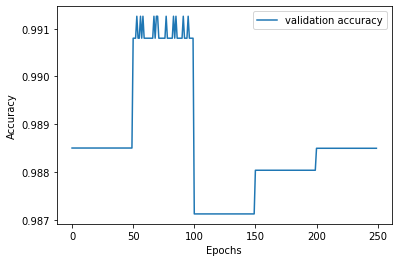

In [ ]:
plt.plot(range((epoch+1)*5), accuracy_list, label = 'validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

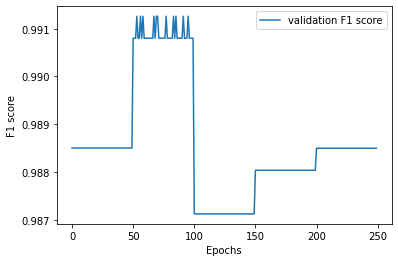

In [ ]:
plt.plot(range((epoch+1)*5), f1_list, label = 'validation F1 score')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.show()

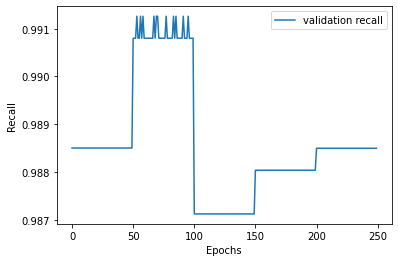

In [ ]:
plt.plot(range((epoch+1)*5), recall_list, label = 'validation recall')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.show()

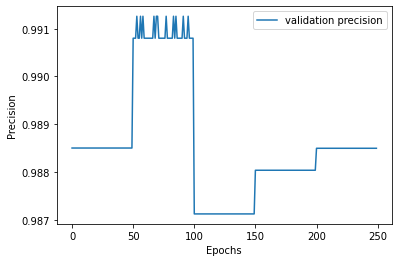

In [ ]:
plt.plot(range((epoch+1)*5), precision_list, label = 'validation precision')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.show()

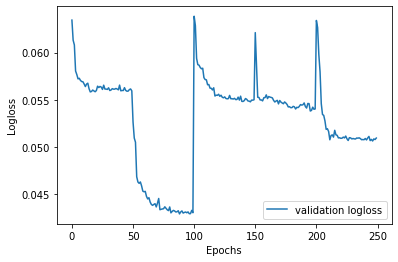

In [ ]:
plt.plot(range((epoch+1)*5), logloss_list, label = 'validation logloss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.show()

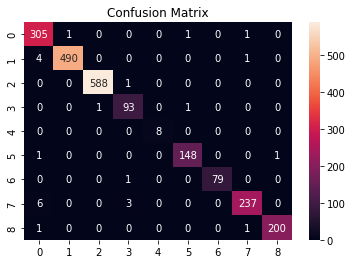

In [ ]:
cm = confusion_matrix(valid_targets, np.array(predictions).argmax(axis=1))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='g')

# Test Data

In [ ]:
test2 = pd.read_csv('/content/drive/MyDrive/FYP/OPCODES_Clean/test_set.csv')

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/embeddings/fastText_testBig15.vectors.txt', delimiter=' ', skiprows=1 ,header = None)
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,vQEo6UfqW8LkBR7dPVSH,0.722050,0.505050,-0.615658,1.397449,0.361419,0.162510,0.004400,-0.444647,0.214738,-0.465133,-0.082847,0.114396,0.084975,-0.125285,-0.804242,-0.096950,-0.512764,-0.612564,0.534618,-0.357879,-0.470035,0.417143,-0.636563,0.012084,-0.254109,0.053036,0.539685,-0.598743,0.284088,0.022535,0.127248,-0.354445,-0.078293,0.583114,-1.150601,0.745077,0.831721,0.196836,0.289787,...,0.198436,-0.325015,0.295675,0.152254,0.146224,0.352717,0.026391,-0.191558,0.268313,0.321153,-0.371031,0.263580,0.006408,0.409645,0.666844,0.144312,0.076407,0.385077,0.347749,-0.156934,0.265624,0.040465,0.054090,0.032735,0.164918,-0.394543,-0.008959,-0.002054,0.353555,-0.890953,0.759933,-0.342078,0.158105,-0.409658,-0.111843,-0.260909,0.090129,0.657309,0.457581,0.458557
1,NmM80oCvG2YwfAWxD1tX,0.491831,0.506405,-0.056495,0.586894,0.381484,0.211667,0.231726,0.707670,-0.020716,0.280406,-0.213773,-0.226268,-0.288602,-0.570046,0.288464,-0.863536,-0.329832,-0.324466,-0.059260,0.211324,0.037098,0.074029,0.010252,-0.458542,0.228296,-0.917126,0.559870,0.204883,0.352994,0.993624,0.049510,-0.309005,0.139125,-0.138645,-0.224156,0.674073,-0.218734,-0.309934,0.075587,...,0.211108,-0.502547,0.387626,0.314584,-0.411473,0.080095,0.376923,-0.310900,-0.090522,0.049307,-0.016190,-0.657755,-0.052813,0.062754,-0.598547,0.303236,0.101845,0.334209,0.437029,-1.043039,-0.315511,-0.103484,0.117568,-0.283852,0.210853,-0.321095,-0.124338,-0.517643,0.123714,-0.071235,0.540862,-0.014834,-0.618000,0.538343,-0.356797,0.416224,-0.907807,0.964762,0.328219,-0.210504
2,ln4EbVcwjKuxtJdQpzP2,0.666259,0.280914,-0.419895,0.728183,0.315383,-0.002967,-0.076242,0.008343,0.044049,-0.295965,-0.107542,0.054256,-0.102294,-0.126450,-0.348064,-0.117289,-0.337930,-0.352994,0.223679,-0.171755,-0.295941,0.255440,-0.342580,-0.042679,0.083831,-0.193467,0.541308,-0.239812,0.220315,0.369261,0.040287,-0.260605,0.023916,0.225765,-0.684864,0.471660,0.580833,-0.054622,0.315616,...,0.014164,-0.338651,0.231093,0.059726,0.120675,0.245296,0.023621,-0.256281,0.171930,0.029960,-0.287226,0.117323,-0.101446,0.428845,0.170637,0.210053,0.241047,0.385158,0.283053,-0.476148,0.135507,-0.035625,-0.011288,0.006172,0.102471,-0.351394,-0.045153,-0.006258,0.141901,-0.590481,0.545844,-0.109671,-0.002565,-0.103166,-0.240563,0.082389,-0.222257,0.601677,0.335706,0.231323
3,OcEtJYaxhQkHzLGweIf5,0.586099,0.712286,0.030633,0.491104,0.387673,0.019486,0.174956,0.980490,-0.157463,0.432459,-0.316892,-0.253727,-0.399484,-0.839203,0.280014,-1.038638,-0.595398,-0.583847,-0.265989,0.296921,0.310788,-0.057797,0.368243,-0.451762,0.453438,-1.035095,0.539609,0.311013,0.694400,1.273080,0.007055,-0.507257,0.401712,-0.472806,-0.065067,0.983026,-0.301146,-0.502397,0.290103,...,0.309491,-0.653502,0.677094,0.585694,-0.682045,0.198949,0.736641,-0.705583,0.029591,0.116668,-0.026861,-0.860645,-0.353860,0.053907,-0.629183,0.483448,0.217812,0.460335,0.696114,-1.505926,-0.488625,-0.264519,0.150530,-0.265073,0.448835,-0.288904,-0.500160,-0.674442,0.208998,-0.356634,0.480436,-0.153586,-0.891348,0.894093,-0.569306,0.582486,-1.461021,1.382342,0.167862,-0.575664
4,xRqDSKGQMzsY41nwL0Zj,0.393419,0.196750,-0.117171,0.207754,0.181341,-0.134658,-0.092964,0.248427,-0.068634,-0.048282,-0.031011,-0.018117,-0.212117,-0.111131,-0.024543,-0.106604,-0.242014,-0.222588,0.082943,-0.060263,-0.139226,0.159847,-0.075971,-0.020670,0.178909,-0.307493,0.441213,0.000330,0.219534,0.423034,0.067741,-0.213153,0.105102,-0.005705,-0.293511,0.309908,0.356168,-0.102414,0.252674,...,-0.023996,-0.292263,0.226150,0.070613,-0.045123,0.121050,0.018201,-0.141694,0.092150,-0.010522,-0.205652,0.006369,-0.113764,0.291877,-0.115301,0.247254,0.193473,0.224068,0.207050,-0.531388,-0.007223,-0.090273,-0.037597,-0.004251,0.079036,-0.184859,-0.089130,-0.045202,0.04

In [ ]:
test_dataset = TestDataset(test.iloc[:,1:].values)

In [ ]:
test_loader = torch.utils.data.DataLoader(
  test_dataset, batch_size=64, shuffle=False, num_workers=4
)

In [ ]:
def inference(data_loader, model, device):
  model.eval()
  
  final_outputs = []
  
  with torch.no_grad():
    for data in tqdm.tqdm(data_loader):
      inputs = data["X"]
      
      inputs = inputs.to(device, dtype=torch.float)
      
      output = model(inputs)
      
      # convert targets and outputs to lists
      output = output.detach().cpu().numpy().tolist()
      
      # extend the original list
      final_outputs.extend(output)
      
  # return final output and final targets
  return final_outputs

In [ ]:
a = time.time()
test2['Opcodes'] = test2['Opcodes'].apply(lambda x: str(x).replace(',',' '))
test_encs = vectorizer.transform(test2['Opcodes'])
test_encs = test_encs.toarray()

test_encs = pd.DataFrame(test_encs)

b = time.time()

print(b-a)

75.79828333854675


In [ ]:
models_nn = [
             '/content/model_fold0_15.pth',
             '/content/model_fold1_38.pth',
             '/content/model_fold2_46.pth',
             '/content/model_fold3_45.pth',
             '/content/model_fold4_46.pth'
]
models_xgb = [
              '/content/xgb_fold0.b5',
              '/content/xgb_fold1.b5',
              '/content/xgb_fold2.b5',
              '/content/xgb_fold3.b5',
              '/content/xgb_fold4.b5'
]

models_lgbm = [
               '/content/lgbm_fold0.b5',
               '/content/lgbm_fold1.b5',
               '/content/lgbm_fold2.b5',
               '/content/lgbm_fold3.b5',
               '/content/lgbm_fold4.b5'
]

In [ ]:
a = time.time()
preds_all = []
for model_nn, model_lgbm, model_xgb in zip(models_nn, models_lgbm, models_xgb):
  model = NeuralNet(100, 9).to(device)
  model, _ = load_checkpoint(model, model_nn)
  model_xgb = pickle.load(open(model_xgb, 'rb'))
  model_lgbm = pickle.load(open(model_lgbm, 'rb'))
  
  nn_preds = inference(test_loader, model, device)
  lgbm_preds = lgbm.predict_proba(test_encs.values)
  xgb_preds = xgb.predict_proba(test_encs.values)

  preds = np.array(nn_preds) * 0.05 + lgbm_preds * 0.45 + xgb_preds * 0.4 
  preds_all.append(preds)
b = time.time()
print(b-a)

100%|██████████| 170/170 [00:01<00:00, 151.84it/s]


11.568378925323486


In [ ]:
print(f'took {600+75+11} seconds to process 10K massive data in 5 folds')
print(f'Each Fold took {(600+75+11)/5} seconds')
print(f'Each sample took {((600+75+11)/5)/11000} seconds ')

took 686 seconds to process 10K massive data in 5 folds
Each Fold took 137.2 seconds
Each sample took 0.012472727272727272 seconds 


In [ ]:
submission = pd.concat([pd.DataFrame(test[0].values, columns=['Id']), 
                        pd.DataFrame(np.array(preds_all).mean(axis=0), columns = [f'Prediction{i}' for i in range(1, 10)]) ], axis=1)

In [ ]:
submission.to_csv('submission.csv', index = False)

In [ ]:
submission

,Id,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5,Prediction6,Prediction7,Prediction8,Prediction9
0,vQEo6UfqW8LkBR7dPVSH,0.000297,0.899238,0.000021,0.000032,0.000018,0.000085,0.000023,0.000255,0.000032
1,NmM80oCvG2YwfAWxD1tX,0.000071,0.000012,0.899752,0.000011,0.000006,0.000045,0.000021,0.000033,0.000050
2,ln4EbVcwjKuxtJdQpzP2,0.000078,0.899368,0.000029,0.000020,0.000041,0.000067,0.000021,0.000338,0.000037
3,OcEtJYaxhQkHzLGweIf5,0.011486,0.000188,0.040309,0.000042,0.000023,0.000371,0.847359,0.000175,0.000047
4,xRqDSKGQMzsY41nwL0Zj,0.000108,0.008713,0.000029,0.001395,0.000053,0.887757,0.000023,0.001814,0.000108
...,...,...,...,...,...,...,...,...,...,...
10868,P8cJR2rmtQsyogSW1wHx,0.000042,0.899837,0.000014,0.000008,0.000010,0.000022,0.000008,0.000041,0.000018
10869,WUdBzo0byj7ATkrpLVZD,0.000088,0.000014,0.899690,0.000011,0.000006,0.000047,0.000017,0.000039,0.000088
10870,PAmjTYxOJna9FUIlH2uX,0.000285,0.000019,0.899422,0.000019,0.000009,0.000087,0.000062,0.000055,0.000042
10871,M5a2VdnysxZf03jpvlqP,0.000103,0.000014,0.899685,0.000012,0.000007,0.000057,0.000019,0.000044,0.000060
